In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
latent_dims = 80
num_epochs = 150
batch_size = 256
capacity = 32
learning_rate = 1e-5
variational_beta = 1
use_gpu = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [ ]:
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
c = 32

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=3, stride=2, padding=1) 
        self.fc_mu = nn.Linear(in_features=c*4*4*4, out_features=latent_dims) 
        self.fc_logvar = nn.Linear(in_features=c*4*4*4, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*4*4*4)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*4, 4, 4) 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) 
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
    
vae = VariationalAutoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 752451


In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(),weight_decay=1e-5, lr=learning_rate, )
vae.train()
train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 150] average reconstruction error: 546029.235571
Epoch [2 / 150] average reconstruction error: 544649.575175
Epoch [3 / 150] average reconstruction error: 537768.317363
Epoch [4 / 150] average reconstruction error: 526775.556043
Epoch [5 / 150] average reconstruction error: 520464.848294
Epoch [6 / 150] average reconstruction error: 516942.126116
Epoch [7 / 150] average reconstruction error: 513414.120536
Epoch [8 / 150] average reconstruction error: 507600.584662
Epoch [9 / 150] average reconstruction error: 502058.415497
Epoch [10 / 150] average reconstruction error: 498647.625159
Epoch [11 / 150] average reconstruction error: 496449.114716
Epoch [12 / 150] average reconstruction error: 494919.878906
Epoch [13 / 150] average reconstruction error: 493773.851084
Epoch [14 / 150] average reconstruction error: 492714.195950
Epoch [15 / 150] average reconstruction error: 491778.458068
Epoch [16 / 150] average reconstruction error: 490926.995855
Epoch [17 / 150] ave

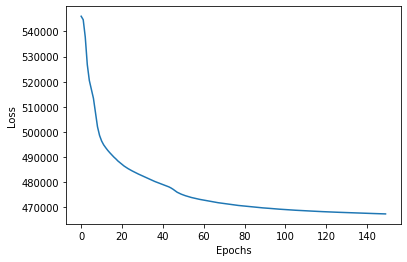

In [ ]:
import matplotlib.pyplot as plt
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
vae

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=80, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=80, out_features=2048, bias=True)
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Original images


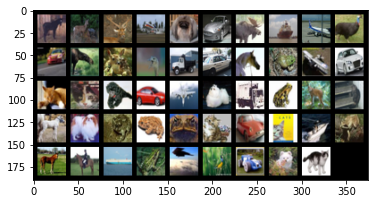

VAE reconstruction:


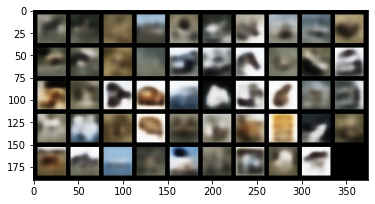

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.savefig('Conv')
        plt.show()

images, labels = iter(test_dataloader).next()

print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

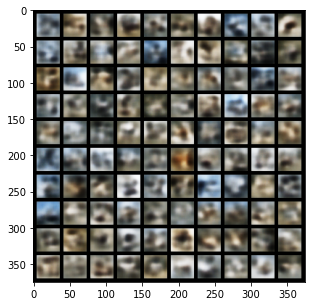

In [ ]:
vae.eval()

with torch.no_grad():
    latent = torch.randn(128, latent_dims, device=device)
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()